In [284]:
import geopandas as gpd
import pandas as pd
import datetime 
import ee
#Pandas modules to interact data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




In [285]:
#ee.Authenticate()
# 4/1AY0e-g6N7hzPKVfIt7WiyOpUr1Kjj2yP7e1H58-az1rfuJMBkfI3q6IELd4
ee.Initialize()


In [286]:

# Set filepath
fp = "data/aoi.shp"
# Read file using gpd.read_file()
shapefile =gpd.read_file(fp)

features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 

fc = ee.FeatureCollection(features)


In [287]:
# import the RS products
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
 
# Define time range
startyear = 2019
endyear = 2020

# Set date in ee date format
startdate = ee.Date.fromYMD(startyear,1,1)
enddate = ee.Date.fromYMD(endyear+1,12,31)

 
# create list for years
years = range(startyear,endyear);
 
# make a list with months
months = range(1,13)

In [288]:
#Filter to select Precipitation band
PrecipitationChirps = chirps.filterDate(startdate, enddate).sort('system:time_start', False).select("precipitation")
 

In [456]:
#pd.DataFrame()
#pd.json_normalize()


In [457]:
# Define geograpic 
# Shapefile to polygon
shapefile =gpd.read_file(fp)
# extract the information needed from the GeoDataFrame to create the feature object. 
features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 
    print(geojsonDict.get('geometry').get('coordinates')[0])
fc = ee.FeatureCollection(features)

[[104.1574694652148, 43.28082512701279], [106.23862359448565, 43.618548374457575], [106.1406869295788, 44.498277862491605], [107.6587052356352, 44.77703004688289], [108.36874605620996, 43.618548374457575], [109.56847020131904, 44.16552050503997], [111.45375100077617, 43.120192911096666], [109.56847020131904, 42.31069284139379], [106.85072775015357, 42.09304382863742], [104.67163695597583, 41.28859028286109], [103.96159613540107, 42.111209878922594], [104.1574694652148, 43.28082512701279]]


In [458]:
# Extract the polygon coordinates
polygon1 = ee.Geometry.Polygon(fc.geometry().coordinates().getInfo()[0])
#polygon=list(shapefile.loc[0][1].exterior.coords)
# Change to list
#polygon=[list(poly) for poly in polygon]


In [439]:
# calculate the monthly Sum
def MonthlySum(imageCollection):
    mylist = ee.List([])
    for y in years:
        for m in months:
            w = imageCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum()
            #mylist = mylist.add(w)
            mylist = mylist.add(w.set('year', y).set('month', m).set('date', ee.Date.fromYMD(y,m,1)).set('system:time_start',ee.Date.fromYMD(y,m,1)))
    return ee.ImageCollection.fromImages(mylist)

In [440]:
# run the calcMonthlyMean function
monthlyChirps = ee.ImageCollection(MonthlySum(PrecipitationChirps))


# select the region of interest, 25000 is the cellsize in meters
monthlyChirps = monthlyChirps.getRegion(polygon1,25000,"epsg:4326").getInfo()


# get january (index = 0)
precipitation = pd.DataFrame(monthlyChirps, columns = monthlyChirps[0])

# remove the first line
precipitation = precipitation[1:]

#to display the data
print(precipitation[['id','longitude','latitude','precipitation']])

      id longitude latitude precipitation
1      0   104.766  41.4348       1.44221
2      1   104.766  41.4348      0.420318
3      2   104.766  41.4348      0.119479
4      3   104.766  41.4348       3.81272
5      4   104.766  41.4348       6.27415
...   ..       ...      ...           ...
3032   7   107.686  44.5789       21.3676
3033   8   107.686  44.5789       7.91872
3034   9   107.686  44.5789        5.8231
3035  10   107.686  44.5789       1.65451
3036  11   107.686  44.5789       1.83438

[3036 rows x 4 columns]


In [441]:
print(precipitation)

      id longitude latitude                                      time  \
1      0   104.766  41.4348  {'type': 'Date', 'value': 1546300800000}   
2      1   104.766  41.4348  {'type': 'Date', 'value': 1548979200000}   
3      2   104.766  41.4348  {'type': 'Date', 'value': 1551398400000}   
4      3   104.766  41.4348  {'type': 'Date', 'value': 1554076800000}   
5      4   104.766  41.4348  {'type': 'Date', 'value': 1556668800000}   
...   ..       ...      ...                                       ...   
3032   7   107.686  44.5789  {'type': 'Date', 'value': 1564617600000}   
3033   8   107.686  44.5789  {'type': 'Date', 'value': 1567296000000}   
3034   9   107.686  44.5789  {'type': 'Date', 'value': 1569888000000}   
3035  10   107.686  44.5789  {'type': 'Date', 'value': 1572566400000}   
3036  11   107.686  44.5789  {'type': 'Date', 'value': 1575158400000}   

     precipitation  
1          1.44221  
2         0.420318  
3         0.119479  
4          3.81272  
5          6.27415

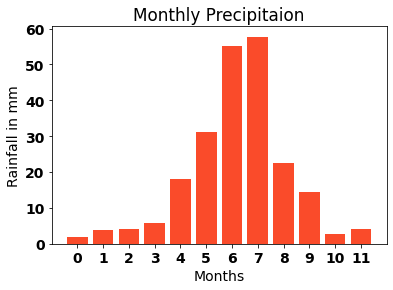

In [435]:
# To display the data in the chart
#style the font size
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

#chart Title
plt.title('Monthly Precipitaion')

#chart lable for x axis
plt.xlabel('Months')

#chart lable for y axis
plt.ylabel('Rainfall in mm')

#chart size and data assign
plt.bar(precipitation['id'], precipitation['precipitation'], color='#fa4b2a')


#export chart as png
plt.savefig('precipitation.png')

In [459]:
boundary = ee.Feature(Countries.first()).geometry().bounds().getInfo()['coordinates']
polygon1 = ee.Geometry.Polygon(fc.geometry().coordinates().getInfo()[0])



NameError: name 'Countries' is not defined

In [460]:
task_config = {
    'fileNamePrefix': 'image',
    'crs': 'EPSG:4326',
    'scale': 500,
    'maxPixels': 10e15,
    'fileFormat': 'GeoTIFF',
    'skipEmptyTiles': True,
    'region': polygon1 ,
    'folder': 'myfolder'
    }

task = ee.batch.Export.image.toDrive(image, str('image'), **task_config)
task.start()

EEException: The field "max_pixels" must have a value between 1 and 10000000000000 inclusive. If unspecified, the default value is 100000000.

In [462]:
boundary = ee.Feature(Countries.first()).geometry().bounds().getInfo()['coordinates']
Export.image.toDrive({
  image: landsat,
  description: 'imageToDriveExample',
  scale: 30,
  region: geometry
});
task_config = {
    'fileNamePrefix': 'image',
    'crs': 'EPSG:4326',
    'scale': 500,
    'maxPixels': 10e15,
    'fileFormat': 'GeoTIFF',
    'skipEmptyTiles': True,
    'region': boundary ,
    'folder': 'myfolder'
    }

task = ee.batch.Export.image.toDrive(image, str('image'), task_config)
task.start()

ee.Image({
  "functionInvocationValue": {
    "functionName": "Image.visualize",
    "arguments": {
      "image": {
        "functionInvocationValue": {
          "functionName": "Image.clip",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "Collection.geometry",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection",
                      "arguments": {
                        "features": {
                          "arrayValue": {
                            "values": [
                              {
                                "functionInvocationValue": {
                                  "functionName": "Feature",
                                  "arguments": {
                                    "geometry": {
                                      "functionInvocationValue": {
              

NameError: name 'rasterio' is not defined

In [465]:
pip install  rasterio

     |████████████████████████████████| 20.5 MB 6.5 MB/s eta 0:00:01    |█████                           | 3.1 MB 3.2 MB/s eta 0:00:06     |███████████████████████████▌    | 17.7 MB 6.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [466]:
import rasterio

In [467]:
with rasterio.open(filepath) as src:
    print(src.profile)

NameError: name 'filepath' is not defined